In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from analysis_utils import *

In [2]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

# Setup

In [3]:
EXPERIMENT = 7

os.makedirs(f'stats/{EXPERIMENT}', exist_ok=True)
def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

data = get_data(EXPERIMENT)
pdf = data['participants'].set_index('pid').copy()
full_pdf = pdf.copy()
mdf = data['trials'].set_index('pid').copy()
mdf.trial_time /= 1000
mdf['clicked'] = mdf.n_clicks > 0

pdf.query('completed', inplace=True)

pdf['test_env'] = pdf.pop('constantTest').apply(lambda x: 'constant' if x else 'increasing')
mdf['test_env'] = pdf.test_env
pdf['feedback'] = 'meta'
mdf['feedback'] = 'meta'

with open('mouselab_maxscores.json') as f:
    maxscores = json.load(f)

each_max = mdf.apply(lambda row: 
    maxscores['basic'] 
    if (row.block == 'training' or row.test_env == 'increasing') 
    else maxscores['unstructured']
, axis=1)
# mdf.score *= (100/each_max)

## Demographics

In [4]:
pids = list(pdf.index.unique())
sdf = data['survey'].rename(columns={'wid': 'pid'}).query('pid == @pids').copy()
if not isinstance(sdf.responses.iloc[0], dict):
    sdf = sdf.loc[~sdf.responses.isna()]
    sdf.responses = sdf.responses.apply(ast.literal_eval)

if EXPERIMENT == 3:
    demo = sdf.loc[sdf.responses.apply(len) == 3].set_index('pid').responses
    age = demo.apply(get('Q1'))
    gender = demo.apply(get('Q2'))
else:
    demo = sdf.loc[sdf.responses.apply(len) == 2].set_index('pid').responses
    age = demo.apply(get('Q0'))
    gender = demo.apply(get('Q1'))
    
gender = gender.str.lower()
age = age.apply(excepts(ValueError, int, lambda _: None))
age.loc[age < 18] = None

write_tex('mean-age', f'${age.mean():.1f}$')
write_tex('min-age', f'${age.min():.0f}$')
write_tex('max-age', f'${age.max():.0f}$')

regularize = {
    'man': 'male',
    'woman': 'female',
    'f': 'female',
    'm': 'male',
}
gender = gender.apply(lambda x: regularize.get(x.strip(), x))
n_fem = gender.value_counts()['female']
write_tex("N-female", f'${n_fem}$')

write_tex("N-total", f"${len(pdf)}$")
for fb, n in pdf.feedback.value_counts().items():
    write_tex(f"N-{fb}", f"${n}$")
    
write_tex('mean-bonus', f'\${pdf.bonus.mean():.2f}')

wrote "$34.8$" to "stats/7/mean-age.tex"
wrote "$18$" to "stats/7/min-age.tex"
wrote "$71$" to "stats/7/max-age.tex"
wrote "$43$" to "stats/7/N-female.tex"
wrote "$102$" to "stats/7/N-total.tex"
wrote "$102$" to "stats/7/N-meta.tex"
wrote "\$1.43" to "stats/7/mean-bonus.tex"


In [5]:
if EXPERIMENT == 3:
    dropped = pdf.query('not completed').feedback.value_counts()
    rate = dropped / pdf.feedback.value_counts()
    for fb in fb_order:
        write_tex(f'N-drop-{fb}', dropped[fb])
        write_tex(f'drop-rate-{fb}', f'${rate[fb]*100:.1f}\%$')
    write_tex('return-rate', f'${pdf.completed.mean()*100:.1f}\%$')
    write_tex('return-N', f'${pdf.completed.sum()}$')
    pdf.query('completed', inplace=True)
    
# pd.Series(pdf.index).to_csv(f'pids/{EXPERIMENT}.csv', index=False, header=False)

In [6]:
completed = list(pdf.index)
mdf.reset_index(inplace=True)
mdf.query('pid == @completed', inplace=True)
mdf.set_index('pid', inplace=True)

# pdf.feedback = pd.Categorical(pdf.feedback, fb_order, ordered=True)    
# mdf['feedback'] = pdf.feedback
block_mean = mdf.groupby(['block', 'pid']).score.mean()
for b in ['training', 'test']:
    pdf[b] = block_mean[b]

In [7]:
small_leaves = {3,4,7,8,11,12}
transfer_leaves = {5, 6, 7, 9, 10, 11, 16, 17, 18, 20, 21, 22, 27, 28, 29, 31, 32, 33}

def clicked_leaf_first(row):
    if not row.clicks:
        return False
    first = row.clicks[0]
    transfer =  EXPERIMENT in (2, 3) and row.block == "test"
    leaves = transfer_leaves if transfer else small_leaves
    return first in leaves

mdf['backward'] = mdf.apply(clicked_leaf_first, axis=1)

## Setup Plotting 

In [8]:
figure = Figures(path=f'figs/{EXPERIMENT}', formats=['pdf', 'png']).plot

sns.set_style('whitegrid')
blue, orange, green, _, purple = sns.color_palette('tab10')[:5]
gray = (0.5,)*3
red = (1, 0.3, 0.4)
yellow = (1, 0.9, 0.4)

palette = {
    'none': gray,
    'action': blue,
    'meta': orange,
    'info_only': red,
    'reward_only': yellow,
    'both': orange,
    'increasing': orange,
    'constant': green,
}

nice_names = {
    'meta': 'Metacognitive',
    'action': 'Action',
    'none': 'None',
    'feedback': 'Feedback',
    'info_only': 'Information\nOnly',
    'reward_only': 'Reward\nOnly',
    'both': 'Information &\nReinforcement',
    'score': 'Relative Score',
    'test': 'Relative Test Score',
    'backward': 'Proportion Planning Backward',
    'constant': 'Constant',
    'increasing': 'Increasing',
    'test_env': 'Test Environment',
}

def reformat_labels(ax=None):
    ax = ax or plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    new_labels = [nice_names.get(lab, lab) for lab in labels]
    ax.set_xticklabels(new_labels)
    
def reformat_legend(ax=None):
    if ax is None:
        ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    print([nice_names.get(l, l).replace('\n', ' ') for l in labels])
    ax.legend(handles=handles, labels=[nice_names.get(l, l).replace('\n', ' ') 
                                       for l in labels])
    
def plot_block_changes():
    block_changes = mdf.loc[1].block.apply(Labeler()).diff().reset_index().query('block == 1').index
    for t in block_changes:
        plt.axvline(t-0.5, c='k', ls='--')

from datetime import datetime
# os.makedirs(f'stats/{EXPERIMENT}/', exist_ok=True)
def result_file(name, ext='tex'):
    file = f'stats/{EXPERIMENT}-{name}.{ext}'
#     with open(file, 'w+') as f:
#         timestamp = datetime.now().strftime('Created on %m/%d/%y at %H:%M:%S\n\n')
#         f.write(timestamp)
    return file

# Learning curves

['Test Environment', 'Increasing', 'Constant']
figs/7/learning_curve_score.pdf
figs/7/learning_curve_score.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

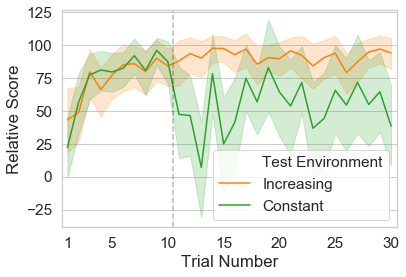

In [9]:
def learning_curve(var, drop_noclick=False):
    df = mdf.copy()
    if drop_noclick:
        df = df.query('clicked')
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='test_env', 
                 data=df, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    split = mdf.query('block == "training"').trial_index.max()
    plt.axvline(split+1.5, c='k', ls='--', alpha=0.3)
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    reformat_legend()
    
figure(var='score')(learning_curve)

['Test Environment', 'Increasing', 'Constant']
figs/7/learning_curve_backward.pdf
figs/7/learning_curve_backward.png


<function analysis_utils.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

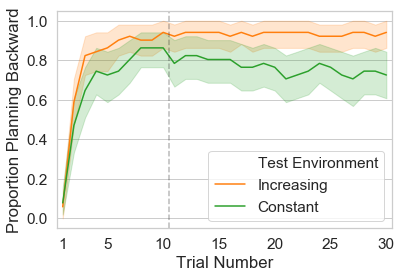

In [10]:
figure(var='backward')(learning_curve)

# Stats

## Score 

In [11]:
x = mdf.query('block == "test" and test_env == "constant"').groupby('backward').score.mean()

In [12]:
rdf = mdf.query('block == "test" and test_env == "constant"').copy()
rdf = rdf[['score', 'backward', 'n_clicks']]
rdf.backward = rdf.backward.astype(int)

In [13]:
%%R -i rdf
summary(lm(score ~ backward, data=rdf))


Call:
lm(formula = score ~ backward, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-374.82  -82.00   19.36   75.83  301.08 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   36.790      7.905   4.654 3.68e-06 ***
backward      22.684      9.040   2.509   0.0123 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 122.5 on 1018 degrees of freedom
Multiple R-squared:  0.006147,	Adjusted R-squared:  0.005171 
F-statistic: 6.297 on 1 and 1018 DF,  p-value: 0.01225



In [14]:
%%R -i rdf
summary(lm(score ~ backward * n_clicks, data=rdf))


Call:
lm(formula = score ~ backward * n_clicks, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-388.48  -65.34    5.71   67.91  309.72 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         28.148     10.126   2.780  0.00554 ** 
backward            69.926     13.269   5.270 1.67e-07 ***
n_clicks             2.938      2.194   1.339  0.18086    
backward:n_clicks  -11.253      2.712  -4.149 3.62e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 120.9 on 1016 degrees of freedom
Multiple R-squared:  0.03371,	Adjusted R-squared:  0.03086 
F-statistic: 11.81 on 3 and 1016 DF,  p-value: 1.306e-07



## Backward chisquare

In [15]:
# df = mdf.query('block == "test"')
from scipy.stats import chisquare
assert mdf.trial_index.max() == 29
def write_backward_prop(drop_noclick):
    df = mdf.query('trial_index == 29')
    if drop_noclick:
        df = df.query('clicked')
    counts = df.groupby(['test_env', 'backward']).apply(len)
    stat, p = chisquare(counts['increasing'], counts['constant'])
    tex = rf'$\chi^2(1) = {int(stat)}, {pval(p)}$'
    name = 'backward-final-clicked' if drop_noclick else 'backward-final'
    write_tex(name, tex)

for x in False, True:
    write_backward_prop(x)

wrote "$\chi^2(1) = 11, p < .001$" to "stats/7/backward-final.tex"
wrote "$\chi^2(1) = 243, p < .001$" to "stats/7/backward-final-clicked.tex"


In [16]:
x = mdf.query('trial_index == 29').groupby('test_env').backward.mean()
for cond, prop in x.items():
    write_tex(f'proportion_strategy_change_trial30_{cond}', f"${(1-prop)*100:.1f}$\%")

wrote "$27.5$\%" to "stats/7/proportion_strategy_change_trial30_constant.tex"
wrote "$5.9$\%" to "stats/7/proportion_strategy_change_trial30_increasing.tex"


## Backward regression 

In [17]:
rdf = mdf.query('block == "test"').copy().reset_index()
# rdf = mdf.query('block == "test" and clicked').copy().reset_index()
rdf = rdf[['backward', 'trial_index', 'test_env', 'pid']]
rdf.backward = rdf.backward.astype(int)
rdf['switch'] = (rdf.pop('test_env') == 'constant').astype(int)
# rdf = rdf.groupby('pid').mean()
rdf.trial_index -= rdf.trial_index.min()

In [18]:
%%R -i rdf
require(ggplot2)
m = glm(backward ~ trial_index * switch, family=binomial, data=rdf)
# m = lm(backward ~ trial_index * switch, data=rdf)
summary(m)

R[write to console]: Loading required package: ggplot2




Call:
glm(formula = backward ~ trial_index * switch, family = binomial, 
    data = rdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3437   0.3660   0.3707   0.7012   0.8145  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         2.680127   0.245030  10.938  < 2e-16 ***
trial_index        -0.002643   0.021920  -0.121    0.904    
switch             -1.243710   0.286304  -4.344  1.4e-05 ***
trial_index:switch -0.023841   0.025422  -0.938    0.348    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1728.1  on 2039  degrees of freedom
Residual deviance: 1603.1  on 2036  degrees of freedom
AIC: 1611.1

Number of Fisher Scoring iterations: 5



In [19]:
from statsmodels.formula.api import glm
import statsmodels.api as sm
glm('backward ~ trial_index * switch', rdf, family=sm.families.Binomial()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               backward   No. Observations:                 2040
Model:                            GLM   Df Residuals:                     2036
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -801.55
Date:                Tue, 30 Nov 2021   Deviance:                       1603.1
Time:                        17:47:17   Pearson chi2:                 2.04e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.6801      0.245     10.938      0.000       2.200       3.160
trial_index           -0.0026      0.022     -0.121      0.904      -0.046       0.040
switch                -1.2437      0.286     -4.344      0.000      -1.805      -0.683
trial_index:switch    -0.0238      0.025     -0.938      0.348      -0.074       0.026
======================================================================================
"""

In [20]:
%%R -i rdf
require(lme4)
summary(glmer(backward ~ trial_index * switch + (1|pid), family=binomial, data=rdf))

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: backward ~ trial_index * switch + (1 | pid)
   Data: rdf

     AIC      BIC   logLik deviance df.resid 
   433.7    461.8   -211.8    423.7     2035 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.1651  0.0024  0.0027  0.0049  2.8439 

Random effects:
 Groups Name        Variance Std.Dev.
 pid    (Intercept) 202.8    14.24   
Number of obs: 2040, groups:  pid, 102

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        12.15068    1.69299   7.177 7.12e-13 ***
trial_index        -0.02467    0.06720  -0.367    0.714    
switch             -0.06423    1.85199  -0.035    0.972    
trial_index:switch -0.11796    0.07478  -1.577    0.115    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) trl_nd switch
trial_index -0.412              
swit

In [21]:
rdf = rdf.groupby('pid').mean()

In [22]:
%%R -i rdf
summary(lm(backward ~ switch, data=rdf))


Call:
lm(formula = backward ~ switch, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.93431  0.06569  0.06569  0.23529  0.23529 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.93431    0.04457  20.965  < 2e-16 ***
switch      -0.16961    0.06302  -2.691  0.00835 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3183 on 100 degrees of freedom
Multiple R-squared:  0.06753,	Adjusted R-squared:  0.05821 
F-statistic: 7.242 on 1 and 100 DF,  p-value: 0.008348



# Process

## Summary in test block

In [23]:
def report_ratio(df, key):
    name = key.replace('_', '-')
    X = df.groupby(['feedback', key]).apply(len)
    rate = 100 * df.groupby('feedback')[key].mean()

    for c in fb_order:
        r = rate[c]
        write_tex(f'{name}-{c}-percent', f"${r:.1f}$\%")


report_ratio(mdf.query('block == "test"').copy(), 'backward')

NameError: name 'fb_order' is not defined

## Mediation

In [ ]:
rdf = mdf.query('block == "test"').copy().rename(columns={'information': 'info'})
# rdf['feedback'] = (rdf.feedback != 'none').astype(int)

if EXPERIMENT == 4:
    factors = ['info', 'reward']
    for c in factors:
        rdf[c] = rdf[c].astype(float)
else:
    factors = ['action', 'meta']
    fb = rdf.pop('feedback')
    for c in factors:
        rdf[c] = (fb == c).astype(int)

rdf['clicked'] = rdf.clicked.astype(int)
rdf = rdf[[*factors, 'backward', 'clicked', 'n_clicks', 'score', 'trial_index', 'stim_i']].reset_index()
rdf.backward.fillna(0, inplace=True)
# rdf.trial_index = rdf.trial_index.astype(float)
# rdf.query('action == 0', inplace=True)
rdf = rdf.groupby('pid').mean()
rdf.trial_index -= rdf.trial_index.min()

In [ ]:
%%R -i rdf -o score
fit = lm(score ~ backward, data=rdf)
score = summary(fit)
score

In [ ]:
score = dict(score.items())
df = score['df'][1]
est, std, t, p = score['coefficients'][1]
write_tex(f'score-backward', f'${est:.3f}$')
write_tex(f'score-backward-test', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

In [ ]:
%%R -i rdf -i EXPERIMENT -o back -o med_out
library(mediation)

if (EXPERIMENT == 1) {
    back_fit = lm(backward ~ action + meta, data=rdf)
    score_fit = lm(score ~ backward + action + meta, data=rdf)
} else {
    back_fit = lm(backward ~ meta, data=rdf)
    score_fit = lm(score ~ backward + meta, data=rdf)
}
med_out = mediate(back_fit, score_fit, treat="meta", mediator="backward")
back = summary(back_fit)
summary(med_out)

In [ ]:
back = dict(back.items())
df = back['df'][1]
for i, name in enumerate(fb_order[1:], start=1):
    est, std, t, p = back['coefficients'][i]
    write_tex(f'backward-lm-{name}', f'$t({df}) = {t:.3f}$, ${pval(p)}$')

In [ ]:
names = {
    'acme': 'd0',
    'ade': 'z0',
    'total': 'tau',
    'prop': 'n0',
}
med = dict(med_out.items())

for k, v in names.items():
    est = med[v + ('.coef' if v == 'tau' else '')][0]
    lo, hi = med[v+'.ci']
    p = med[v+'.p'][0]
    write_tex(f'mediation-{k}', f'{est:.3f}')
    write_tex(f'mediation-{k}-ci', f'95\% CI: [{lo:.3f}, {hi:.3f}], ${pval(p)}$')

In [ ]:
print("Success!")